## Import libraries


In [10]:
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

## Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

## Metrics

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

## discretizers
from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.discretisers import EqualWidthDiscretiser
from feature_engine import discretisers as dsc

## Model selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectFromModel


from yellowbrick.classifier import ClassPredictionError

## Load data

In [11]:
### Load data

data = pd.read_csv("default of credit card clients.csv",header=1)

## Data Preprocessing


In [12]:
## Drop irrelavant column

data.drop('ID', axis=1, inplace=True) 

In [13]:
## Rename columns
# SEX can be renamed as GENDER
# PAY_0 can be renamed to PAY_1
# default payment next month can be renamed as DEFAULT_STATUS

data.rename(columns = {'SEX': 'GENDER',
                       'PAY_0':'PAY_1',
                       'default payment next month': 'DEFAULT_STATUS'}, inplace = True) 

In [14]:
## Change -2,-1 in Payment status columns PAY_1 to PAY_6 as 0
## From business point of view, -2: No Consumption, -1: Paid in full, and 0: Use of revolving credit are all good
## Machine learning algo might consider -2,-1 as bad whereas its good. So, converting to 0

Columns=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

for i in range(len(Columns)):
    data[Columns[i]] = data[Columns[i]].replace(-2,0)
    data[Columns[i]]= data[Columns[i]].replace(-1,0)
    i=i+1

### Label encoding Categorical columns

In [15]:
## Label encoding for modeling
## Label encode Gender and Default status columns

## Create instance, fit to column and transform the values to labels

le = LabelEncoder()
le.fit(data['GENDER'])
data['GENDER'] = le.transform(data['GENDER'])


## Create instance, fit to column and transform the values to labels

LE = LabelEncoder()
LE.fit(data['DEFAULT_STATUS'])
data['DEFAULT_STATUS'] = LE.transform(data['DEFAULT_STATUS'])


### One hot encoding categorical columns

In [16]:
## One hot encoding EDUCATION column

data=pd.get_dummies(data, prefix=['EDUCATION'], columns=['EDUCATION'])

## One hot encode MARRIAGE column

data['MARRIAGE'].replace({1: "Married",
                          2: "Single",
                          3: "Divorced",
                          0: "Others"}, inplace=True)
data=pd.get_dummies(data, prefix=['MARRIAGE'], columns=['MARRIAGE'])

### Correlation matrix


In [17]:
corrmat=data.corr()
corrmat

,LIMIT_BAL,GENDER,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT6,DEFAULT_STATUS,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_Divorced,MARRIAGE_Married,MARRIAGE_Others,MARRIAGE_Single
LIMIT_BAL,1.000000,-0.024755,0.144713,-0.170745,-0.197136,-0.191323,-0.180629,-0.170045,-0.167820,0.285430,...,0.219595,0.153520,0.258777,-0.139686,0.013420,-0.147530,-0.055806,0.103701,-0.011299,-0.090998
GENDER,-0.024755,1.000000,0.090874,0.034475,0.044750,0.041227,0.039737,0.038533,0.032061,0.033642,...,0.002766,-0.039961,0.022750,0.007650,-0.008498,-0.025353,0.001985,-0.030463,-0.011895,0.031004
AGE,0.144713,0.090874,1.000000,-0.001447,-0.008774,-0.014266,-0.007288,-0.013277,-0.016948,0.056239,...,0.019478,-0.013890,-0.100423,0.231252,0.008982,-0.077626,0.082771,0.449425,0.010731,-0.466584
PAY_1,-0.170745,0.034475,-0.001447,1.000000,0.698389,0.516970,0.460224,0.424473,0.373805,-0.000819,...,-0.048733,-0.396019,-0.067995,0.041765,-0.025452,0.040454,0.004147,0.013018,0.000760,-0.013915
PAY_2,-0.197136,0.044750,-0.008774,0.698389,1.000000,0.663529,0.512773,0.462717,0.407086,0.011684,...,-0.043099,-0.327093,-0.083577,0.043848,-0.038173,0.056992,-0.000149,0.009907,0.002666,-0.010084
PAY_3,-0.191323,0.041227,-0.014266,0.516970,0.663529,1.000000,0.678931,0.551430,0.492827,-0.020586,...,-0.048443,-0.286999,-0.071695,0.041790,-0.041272,0.047909,0.004407,-0.001122,0.007540,-0.000433
PAY_4,-0.180629,0.039737,-0.007288,0.460224,0.512773,0.678931,1.000000,0.745419,0.602875,-0.025184,...,-0.048828,-0.269055,-0.068194,0.039355,-0.036438,0.045161,0.004421,0.004442,0.004160,-0.005701
PAY_5,-0.170045,0.038533,-0.013277,0.424473,0.462717,0.551430,0.745419,1.000000,0.740357,-0.018581,...,-0.046110,-0.260850,-0.057303,0.029218,-0.035103,0.041920,-0.004745,0.001728,0.001138,-0.000840
PAY_6,-0.167820,0.032061,-0.016948,0.373805,0.407086,0.492827,0.602875,0.740357,1.000000,-0.019581,...,-0.045358,-0.244437,-0.047115,0.020009,-0.034603,0.038871,0.001724,-0.002308,0.003040,0.001689
BILL_AMT1,0.285430,0.033642,0.056239,-0.000819,0.011684,-0.020586,-0.025184,-0.018581,-0.019581,1.000000,...,0.179341,0.019644,-0.024045,-0.022006,0.036364,0.030323,-0.011401,0.025264,-0.017775,-0.021347


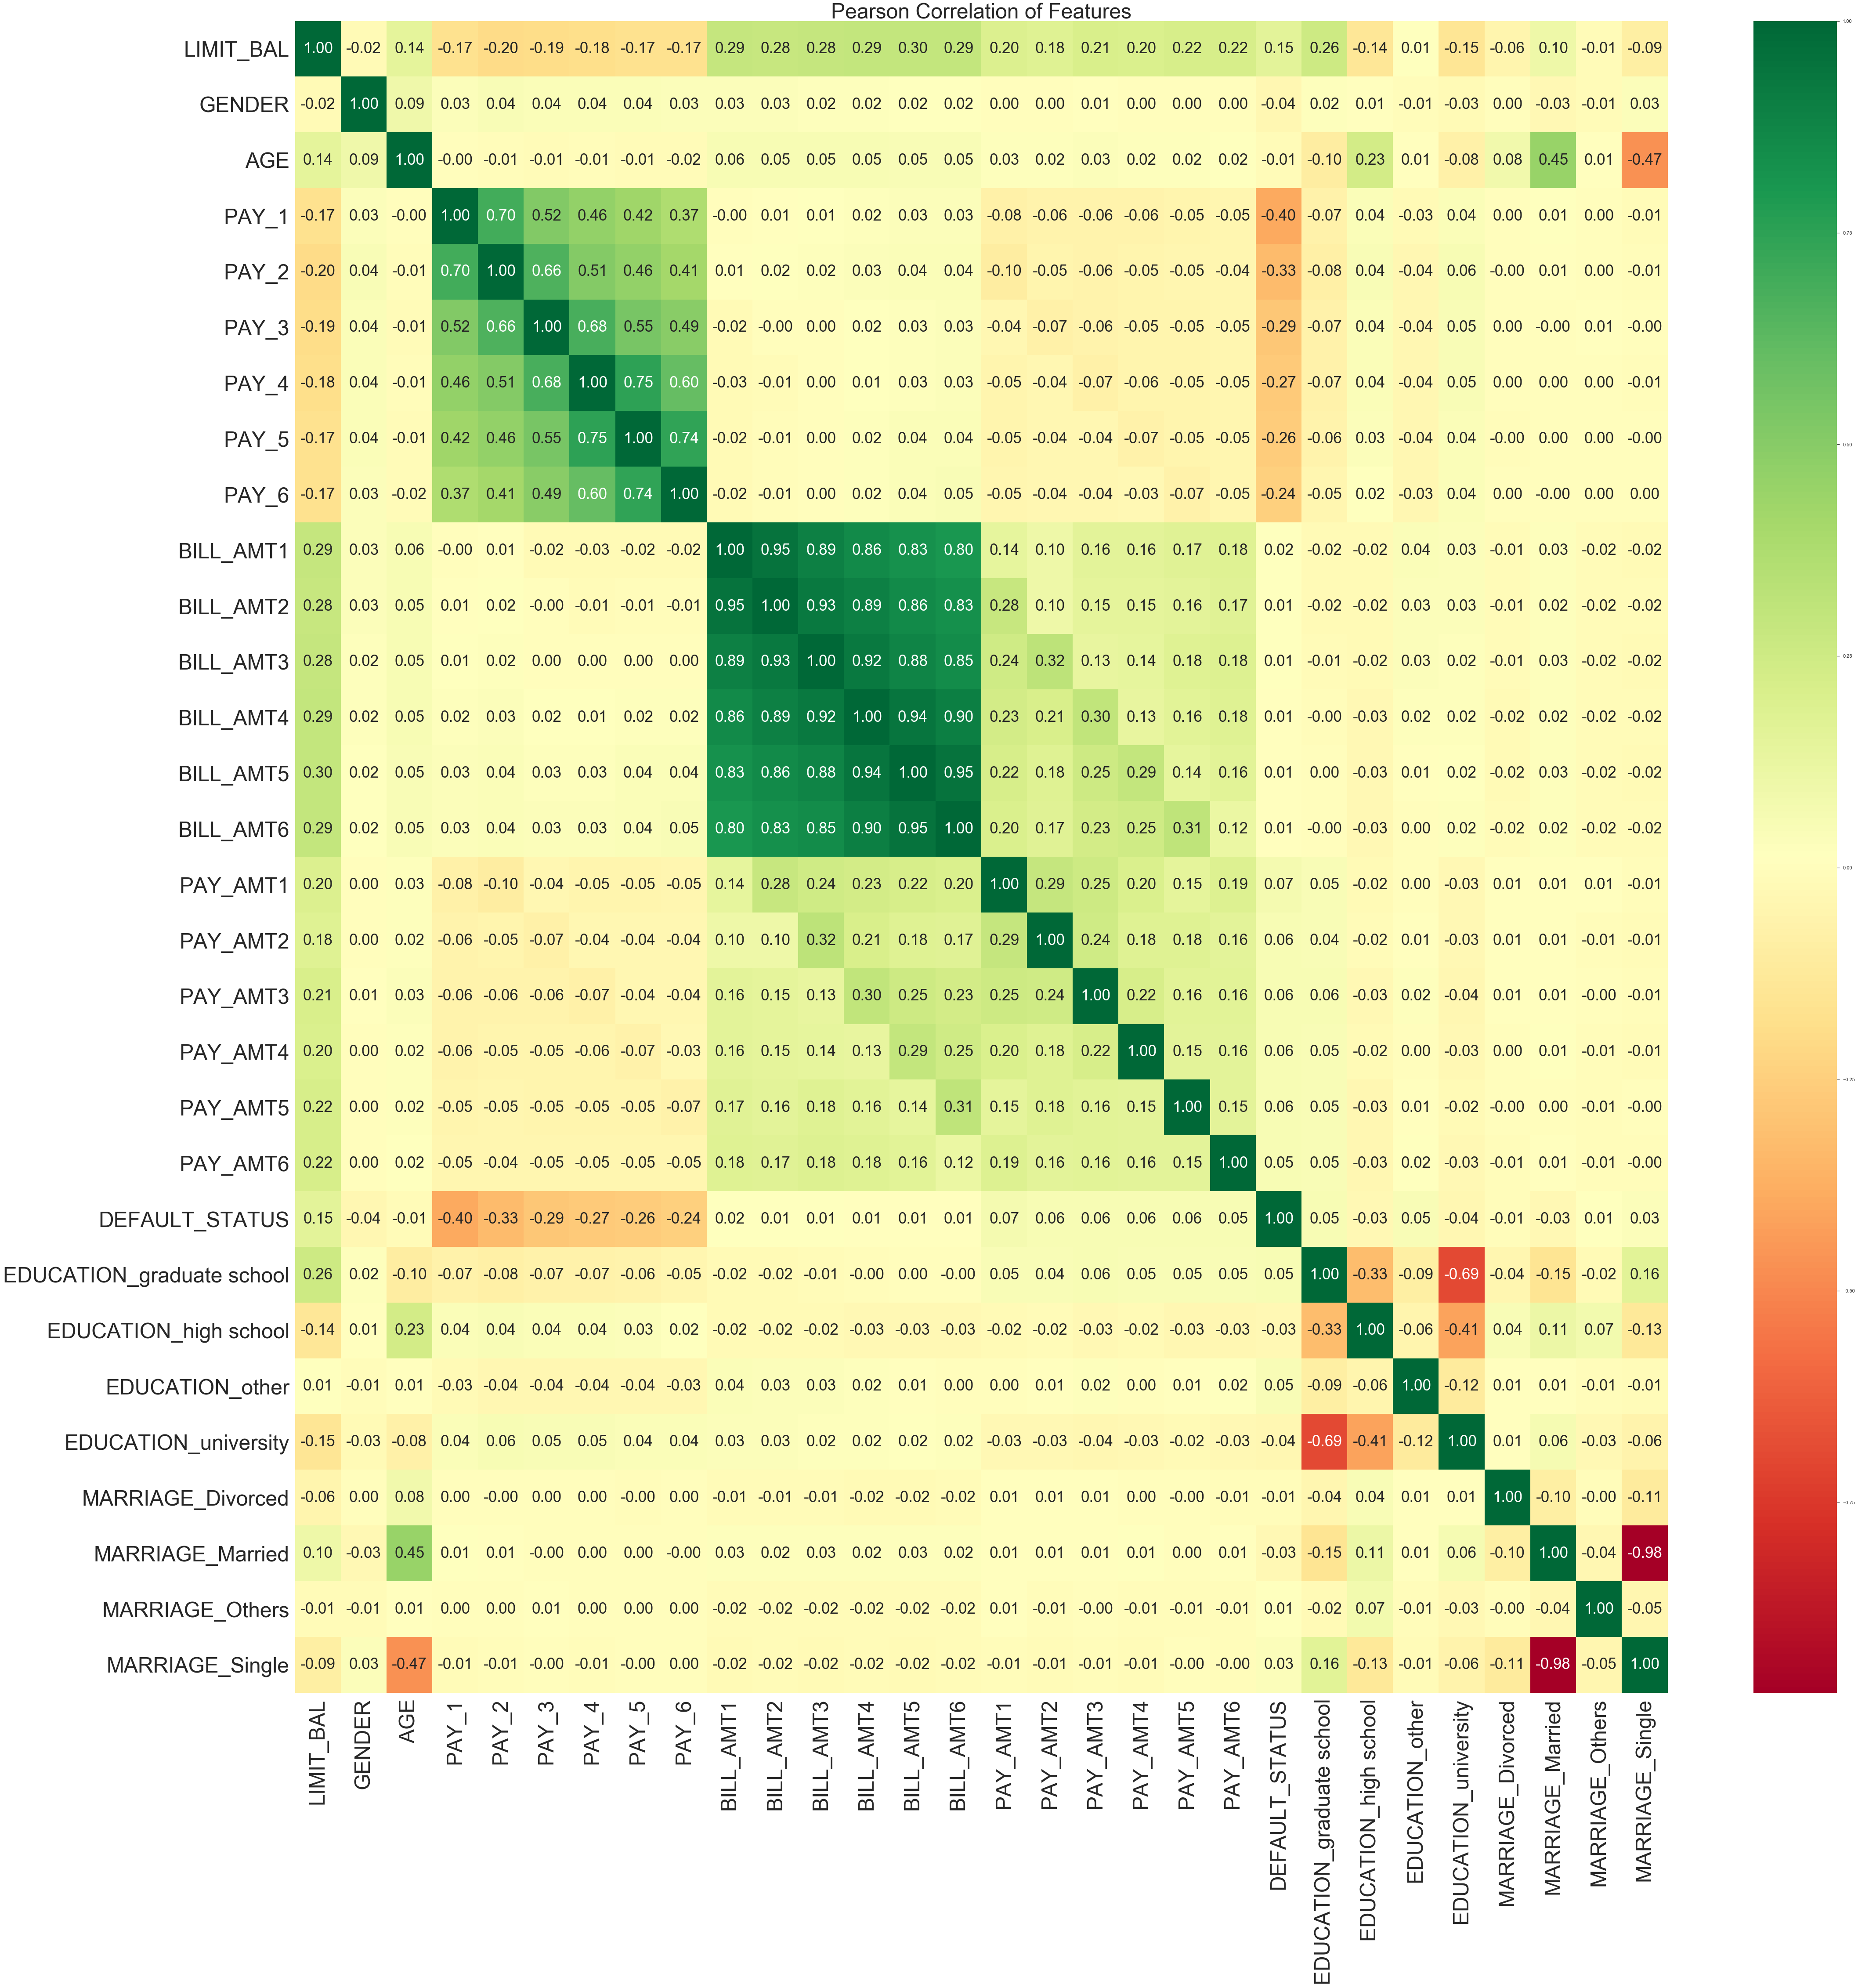

In [18]:
## Visualize the Correlation matrix

# Configure x and y axis
sns.set()
plt.figure(figsize=(70,70))
plt.xticks(fontsize=48)
plt.yticks(fontsize=48)
plt.title('Pearson Correlation of Features', size =48)

# Plotting the data using heatmap
g = sns.heatmap(corrmat,annot=True,cmap="RdYlGn",annot_kws={"size": 35},fmt=".2f")

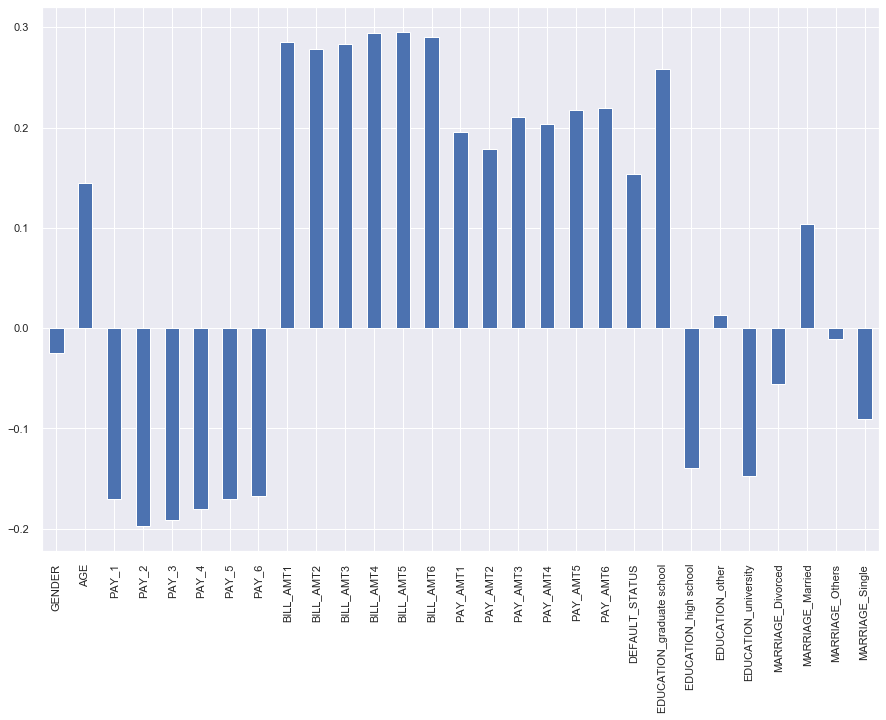

In [19]:
## Pairwise correlation with Target Variable

Limit_bal_corr = corrmat.iloc[0,1:]
Limit_bal_corr.plot(kind='bar',figsize=(15,10))

## Feature Selection for modeling

#### Filter method

In [20]:
#Correlation with output variable

cor_target = abs(corrmat["LIMIT_BAL"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

LIMIT_BAL                    1.000000
BILL_AMT1                    0.285430
BILL_AMT2                    0.278314
BILL_AMT3                    0.283236
BILL_AMT4                    0.293988
BILL_AMT5                    0.295562
BILL_AMT6                    0.290389
PAY_AMT3                     0.210167
PAY_AMT4                     0.203242
PAY_AMT5                     0.217202
PAY_AMT6                     0.219595
EDUCATION_graduate school    0.258777
Name: LIMIT_BAL, dtype: float64

#### OBSERVATION: Bill amount and payment amount are the main features to be considered for modeling using Filter method

### Let us discretize the target variable LIMIT_BAL to consider this as classification problem


#### Using EqualFrequencyDiscretiser to bin the variable. LIMIT_BAL is discretized into 5 bins

In [21]:
## Storing the LIMT_BAL values in another column before discretisation
data['Credit_limit']=data['LIMIT_BAL']
data['LIMIT_BAL_1']=data['LIMIT_BAL']

## Discretisation using equal frequency and  4 bins
disc = dsc.EqualFrequencyDiscretiser(q=4, variables=['LIMIT_BAL'])
disc.fit(data)
data= disc.transform(data)

## Discretisation using equal width and 5 bins

disc = dsc.EqualWidthDiscretiser(bins=5, variables=['LIMIT_BAL_1'])
disc.fit(data)
data= disc.transform(data)

#### Visualizing the bins created by equal frequency discretiser

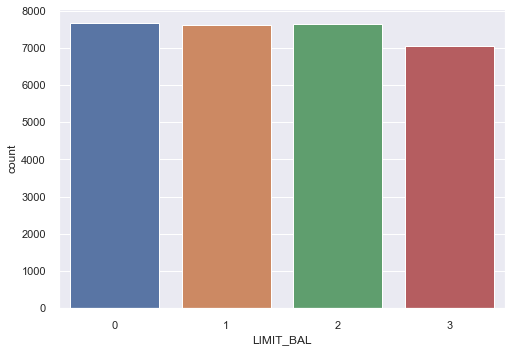

In [22]:
sns.countplot(data=data,x='LIMIT_BAL')

####  Getting the range for each bin

In [23]:
data.groupby('LIMIT_BAL').aggregate(Minimum =('Credit_limit','min'),
                                    Maximum =('Credit_limit','max'),
                                    Total_count=('Credit_limit','count'))

,Minimum,Maximum,Total_count
LIMIT_BAL,,,
0,10000,50000,7676
1,60000,140000,7614
2,150000,240000,7643
3,250000,1000000,7067


#### Visualizing the bins created by equal width discretiser

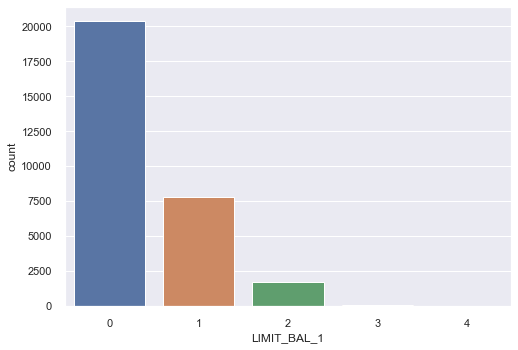

In [24]:
sns.countplot(data=data,x='LIMIT_BAL_1')

#### Getting the range for each bin

In [25]:
data.groupby('LIMIT_BAL_1').aggregate(Minimum =('Credit_limit','min'),
                                    Maximum =('Credit_limit','max'),
                                     Total_count=('Credit_limit','count'))

,Minimum,Maximum,Total_count
LIMIT_BAL_1,,,
0,10000,200000,20378
1,210000,400000,7818
2,410000,600000,1725
3,610000,800000,78
4,1000000,1000000,1


## Case 1: Target variable discretized by EqualFrequency

#### Selecting all features for training

In [26]:
X = data.iloc[:,1:30]
y = data['LIMIT_BAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=123)
X_train.shape


(21000, 29)

### Comparing different models

In [27]:
algosClass = []

algosClass.append(('Random Forest Classifier',RandomForestClassifier()))

algosClass.append(('GradientBoostingClassifier',GradientBoostingClassifier()))

algosClass.append(('Support Vector Classifier',SVC()))


results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.5807000000000001
GradientBoostingClassifier 0.5901000000000001
Support Vector Classifier 0.5338333333333333


#### Gradient Boosting is best with 59.01% accuracy followed by Random Forest with 58.02% accuracy

### Tune hyperparameters to improve accuracy

### Randomized search for Random Forest Classifier

In [28]:
# Setting the parameters

n_estimators = [100, 300]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

# Assigning the classifier
forest = RandomForestClassifier()

# Assigning parameters
params = dict(n_estimators = n_estimators,
              max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)


clf = RandomizedSearchCV(forest, params, cv = 3, verbose = 1, n_jobs = -1)

# Fit the grid search
clf.fit(X_train, y_train)

print(clf.best_estimator_.get_params())


# print best parameter after tuning 
print(clf.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(clf.best_estimator_) 

print(clf.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.7s finished


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_depth': 30}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=No

##### Best hyperparameters are 'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_depth': 30

### Grid Search for Gradient Boosting Classifier

In [29]:
# defining parameter range 
param_grid = {'max_depth': [3,5,8,10]}
             
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, refit = True, verbose = 0,n_jobs=-1,cv=5, scoring='accuracy') 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

print(grid.best_score_)

{'max_depth': 3}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.5885714285714286


##### Best hyperparameters are  max_depth=3

### Grid Search for Support Vector Classifier

In [30]:
# defining parameter range 
param_grid = {'C': [10,100], 
              'kernel': ['rbf']}
                         
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0,n_jobs=-1,cv=5, scoring='accuracy') 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

print(grid.best_score_)

{'C': 100, 'kernel': 'rbf'}
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.5438095238095239


### Compare models with new hyperparameters

In [31]:
algosClass = []

algosClass.append(('Random Forest Classifier',RandomForestClassifier(n_estimators = 300,
              max_depth = 15,  
              min_samples_split = 5, 
              min_samples_leaf = 1)))

algosClass.append(('GradientBoostingClassifier',GradientBoostingClassifier(max_depth=3)))

algosClass.append(('Support Vector Classifier',SVC(C=100,kernel='rbf')))


results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Classifier 0.5873
GradientBoostingClassifier 0.5900666666666666
Support Vector Classifier 0.5457000000000001


### Accuracy has improved a little after hyperparameter tuning. Gradient Boosting is 59% accurate

### Predict test data

### Using Support Vector Classifier

In [32]:
algo= SVC(C=100, kernel='rbf')
model = algo.fit(X_train,y_train)

y_pred = model.predict(X_test)


# Assess the performance of the model on test data
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n" ,cf_matrix)

              precision    recall  f1-score   support

           0       0.66      0.73      0.70      2301
           1       0.57      0.51      0.54      2252
           2       0.42      0.59      0.49      2361
           3       0.63      0.34      0.44      2086

    accuracy                           0.55      9000
   macro avg       0.57      0.54      0.54      9000
weighted avg       0.57      0.55      0.54      9000

Accuracy: 0.5488888888888889
Confusion matrix:
 [[1689  184  394   34]
 [ 476 1144  554   78]
 [ 217  443 1394  307]
 [ 163  245  965  713]]


Text(0.5, 1, ' Confusion Matrix of Support Vector Classifier')

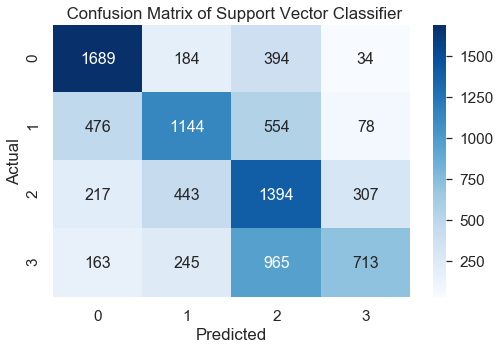

In [35]:
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.title(" Confusion Matrix of Support Vector Classifier")

### Using Random Forest Classifier

In [36]:
algo= RandomForestClassifier(n_estimators = 300,
              max_depth = 15,  
              min_samples_split = 10, 
              min_samples_leaf = 1)
model = algo.fit(X_train,y_train)

y_pred = model.predict(X_test)


# Assess the performance of the model on test data
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n" ,cf_matrix)

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      2301
           1       0.59      0.54      0.56      2252
           2       0.47      0.48      0.48      2361
           3       0.58      0.50      0.54      2086

    accuracy                           0.59      9000
   macro avg       0.58      0.59      0.58      9000
weighted avg       0.58      0.59      0.58      9000

Accuracy: 0.5887777777777777
Confusion matrix:
 [[1905  173  165   58]
 [ 503 1217  390  142]
 [ 222  461 1142  536]
 [ 120  220  711 1035]]


Text(0.5, 1, ' Confusion Matrix of Random Forest Classifier')

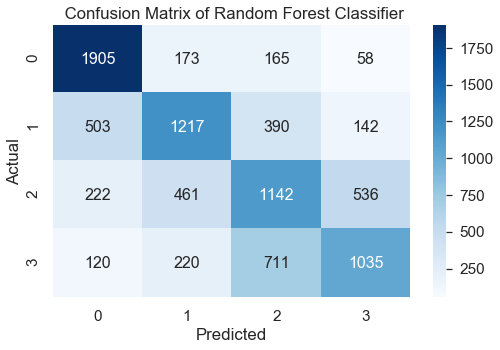

In [37]:
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.title(" Confusion Matrix of Random Forest Classifier")

### Using Gradient Boosting Classifier

In [38]:
algo= GradientBoostingClassifier()
model = algo.fit(X_train,y_train)

y_pred = model.predict(X_test)


# Assess the performance of the model on test data
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n" ,cf_matrix)

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2301
           1       0.58      0.55      0.56      2252
           2       0.47      0.48      0.47      2361
           3       0.59      0.51      0.55      2086

    accuracy                           0.59      9000
   macro avg       0.59      0.59      0.59      9000
weighted avg       0.59      0.59      0.59      9000

Accuracy: 0.5907777777777777
Confusion matrix:
 [[1896  182  167   56]
 [ 481 1228  406  137]
 [ 192  489 1125  555]
 [ 101  224  693 1068]]


Text(0.5, 1, ' Confusion Matrix of Gradient Boosting Classifier')

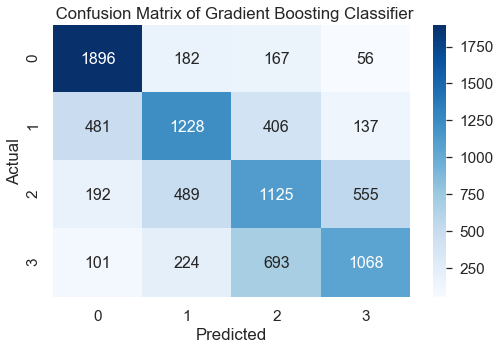

In [39]:
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.title(" Confusion Matrix of Gradient Boosting Classifier")

C:\Users\PriyaSriram\Anaconda3\envs\DataScience\lib\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


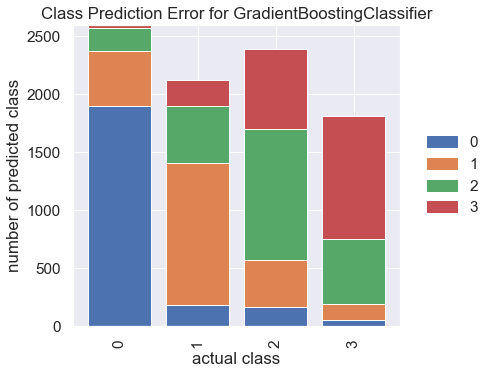

In [40]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    GradientBoostingClassifier(), classes=[0,1,2,3]
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

## Case 2: Using dependent variable discretized by Equal Width

### Using LIMIT_BAL_1 as dependent variable

In [41]:
X = data.iloc[:,1:30]
y = data['LIMIT_BAL_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=123)
X_train.shape

(21000, 29)

### Comparing different models

In [42]:
algosClass = []

algosClass.append(('Random Forest Classifier',RandomForestClassifier()))

algosClass.append(('GradientBoostingClassifier',GradientBoostingClassifier()))

algosClass.append(('Support Vector Classifier',SVC()))


results = []
names = []
for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
for i in range(len(names)):
    print(names[i],results[i].mean())

C:\Users\PriyaSriram\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\PriyaSriram\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\PriyaSriram\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Random Forest Classifier 0.7372666666666667
GradientBoostingClassifier 0.7426333333333334
Support Vector Classifier 0.7229666666666666


## Train the model and predict test data using best model

In [43]:
algo= GradientBoostingClassifier()
model = algo.fit(X_train,y_train)

y_pred = model.predict(X_test)


# Assess the performance of the model on test data
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n" ,cf_matrix)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6133
           1       0.57      0.44      0.50      2331
           2       0.58      0.16      0.25       512
           3       0.00      0.00      0.00        24

    accuracy                           0.74      9000
   macro avg       0.49      0.38      0.40      9000
weighted avg       0.72      0.74      0.72      9000

Accuracy: 0.7448888888888889
Confusion matrix:
 [[5595  517   12    9]
 [1248 1028   43   12]
 [ 175  251   81    5]
 [   7   14    3    0]]


### Accuracy is  74.48%


Text(0.5, 1, ' Confusion Matrix of Gradient Boosting Classifier')

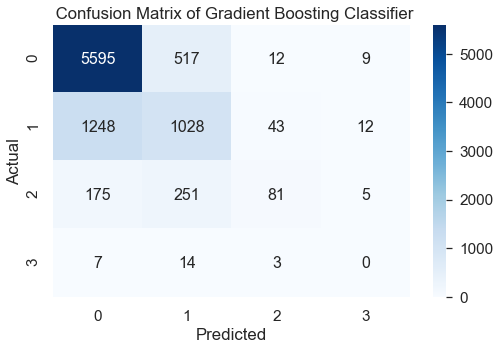

In [44]:
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size
plt.title(" Confusion Matrix of Gradient Boosting Classifier")

### Summary:

Though equal width discretisation seems to give better results, it has to be noted that almost 68% of the total dataset is in bin 1 and its heavily skewed. 68% of the Customers have credit limit less than 200k.

Equal Frequency discretiser divided the dataset equally among 4 bins and though its accuracy is 59% max, it s better in predicting the credit limit for customers below 200k as the bins are dvided as 0-50k, 60k-140k, 150-240k and 250k-1000k


Gradient Boosting gives the best accuracy of 74.48% for equal width discretisation and 59% for equal frequency discretisation